In [1]:
#本脚本主要实现内容为基于tripadvisor澳门地区酒店数据图像识别内容之后文本内容的数据预处理部分

In [2]:
#　导入必要的包
import csv
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster,cut_tree,cophenet,inconsistent
import scipy.cluster.hierarchy as sch
from matplotlib import pyplot as plt
from matplotlib.pyplot import xticks
import pandas as pd
from scipy.spatial import distance
from itertools import groupby #itertool还包含有其他很多函数，比如将多个list联合起来
import json
from sklearn.metrics.pairwise import euclidean_distances
import re
from orangecontrib.associate.fpgrowth import * 
from collections import Counter
from gensim.models import KeyedVectors


import pickle

In [3]:
'''
函数名：读数据
输入：json数据的路径
输出：每张图片用list数据存储的label集，每个图片label的评分集，以及每个图片的url
描述：该函数实现从文件中读取json数据文件，并分别解析出label集，评分集，以及url集
'''
def loadjson_label(path):
    with open (path,'rb') as json_data:
        data = json.load(json_data)
    labels = []
    
    #打印所有的labels
    for i in data:
        labels.append(i[:-1])
    classes = []
    for i in labels:
        temp = []
        for j in i:
            c = list(j[0].values())
            temp.append(c[0])
        classes.append(temp)
    
    # 打印所有的score
    score = []
    for i in labels:
        temp = []
        for j in i:
            c = list(j[1].values())
            temp.append(c[0])
        score.append(temp)

    
    #打印所有的urls
    urls = []
    for i in data:
        urls.append(list(i[-1].values())[0])    
    return classes, score, urls

In [4]:
# 读数据face
def loadjson_face(path):
    with open (path,'rb') as json_data:
        data = json.load(json_data)
    data_with_face = []
    for i in data:
        if len(i)!=1:
            data_with_face.append(i)
    rate = len(data_with_face)/len(data)
#     print ("识别出来脸总共：",len(data_with_face))
#     print ("总数据：",len(data))
    return data,data_with_face,rate

In [5]:
# 读数据color
def loadjson_color(path):
    with open (path,'rb') as json_data:
        data = json.load(json_data)
    labels = []
    # #打印所有的了labels
    for i in data:
        labels.append(i[:-1])
    temp = []
    for i in labels:
        temp_t = []
        for j in i:
            temp_t.append(j[:4])
        temp.append(temp_t)

    urls = []
    for i in data:
        urls.append(i[-1])

    datasets = []
    for i in range(0,len(temp)):
        datasets.append(list(temp[i])+list(urls[i].values()))
        
    return datasets

In [6]:
# 读label
print('====================================官方数据集label识别结果=======================================')
official_labelset_five,official_score_five, official_urls_five = loadjson_label('dataset\official\google\label\\five.json')
print('五星级酒店图片总共:',len(official_labelset_five))
official_labelset_four,official_score_four, official_urls_four = loadjson_label('dataset\official\google\label\\four.json')
print ('四星级酒店图片总共:',len(official_labelset_four))
official_labelset_three,official_score_three, official_urls_three = loadjson_label('dataset\official\google\label\\three.json')
print ('三星级酒店图片总共:',len(official_labelset_three))
official_labelset_two,official_score_two, official_urls_two = loadjson_label('dataset\official\google\label\\two.json')
print ('二星级酒店图片总共:',len(official_labelset_two))
print('总数据量：',len(official_labelset_five)+len(official_labelset_four)+len(official_labelset_three)+len(official_labelset_two))

# 读color
print('=====================================官方数据集color识别结果========================================')
official_colorset_five = loadjson_color('dataset\official\google\color\\five.json')
print('五星级酒店可识别颜色图片总数：',len(official_colorset_five))
official_colorset_four = loadjson_color('dataset\official\google\color\\four.json')
print('四星级酒店可识别颜色图片总数：',len(official_colorset_four))
official_colorset_three= loadjson_color('dataset\official\google\color\\three.json')
print('三星级酒店可识别颜色图片总数：',len(official_colorset_three))
official_colorset_two= loadjson_color('dataset\official\google\color\\two.json')
print('二星级酒店可识别颜色图片总数：',len(official_colorset_two))
print ('总数据量：',len(official_colorset_five)+len(official_colorset_four)+len(official_colorset_three)+len(official_colorset_two))

# 读face
print ('======================================官方数据集face识别结果=======================================')
#其中faceset_five表示五星级酒店总数据，face_five表示识别出来脸的图片集，rate_five表示评分
official_faceset_five,official_face_five,official_rate_five = loadjson_face('dataset\official\google\\face\\five.json')
print('五星级酒店识别出来脸的图片：',len(official_face_five))
official_faceset_four,official_face_four,official_rate_four = loadjson_face('dataset\official\google\\face\\four.json')
print('四星级酒店识别出来脸的图片：',len(official_face_four))
official_faceset_three,official_face_three,official_rate_three = loadjson_face('dataset\official\google\\face\\three.json')
print('三星级酒店识别出来脸的图片：',len(official_face_three))
official_faceset_two,official_face_two,official_rate_two = loadjson_face('dataset\official\google\\face\\two.json')
print('二星级酒店识别出来脸的图片：',len(official_face_two))
print ('总共识别出来脸的图片数据量：',len(official_face_five)+len(official_face_four)+len(official_face_three)+len(official_face_two))

====================================官方数据集label识别结果=======================================
五星级酒店图片总共: 1221
四星级酒店图片总共: 849
三星级酒店图片总共: 222
二星级酒店图片总共: 105
总数据量： 2397
=====================================官方数据集color识别结果========================================
五星级酒店可识别颜色图片总数： 1221
四星级酒店可识别颜色图片总数： 849
三星级酒店可识别颜色图片总数： 222
二星级酒店可识别颜色图片总数： 105
总数据量： 2397
======================================官方数据集face识别结果=======================================
五星级酒店识别出来脸的图片： 26
四星级酒店识别出来脸的图片： 11
三星级酒店识别出来脸的图片： 0
二星级酒店识别出来脸的图片： 0
总共识别出来脸的图片数据量： 37


In [7]:
# 读label
print('====================================游客数据集label识别结果=======================================')
traveler_labelset_five,traveler_score_five, traveler_urls_five = loadjson_label('dataset\\travelers\google\label\\five.json')
print('五星级酒店图片总共:',len(traveler_labelset_five))
traveler_labelset_four,traveler_score_four, traveler_urls_four = loadjson_label('dataset\\travelers\google\label\\four.json')
print ('四星级酒店图片总共:',len(traveler_labelset_four))
traveler_labelset_three,traveler_score_three, traveler_urls_three = loadjson_label('dataset\\travelers\google\label\\three.json')
print ('三星级酒店图片总共:',len(traveler_labelset_three))
traveler_labelset_two,traveler_score_two, traveler_urls_two = loadjson_label('dataset\\travelers\google\label\\two.json')
print ('二星级酒店图片总共:',len(traveler_labelset_two))
print('总数据量：',len(traveler_labelset_five)+len(traveler_labelset_four)+len(traveler_labelset_three)+len(traveler_labelset_two))

# 读color
print('=====================================游客数据集color识别结果========================================')
traveler_colorset_five = loadjson_color('dataset\\travelers\google\color\\five.json')
print('五星级酒店可识别颜色图片总数：',len(traveler_colorset_five))
traveler_colorset_four = loadjson_color('dataset\\travelers\google\color\\four.json')
print('四星级酒店可识别颜色图片总数：',len(traveler_colorset_four))
traveler_colorset_three= loadjson_color('dataset\\travelers\google\color\\three.json')
print('三星级酒店可识别颜色图片总数：',len(traveler_colorset_three))
traveler_colorset_two= loadjson_color('dataset\\travelers\google\color\\two.json')
print('二星级酒店可识别颜色图片总数：',len(traveler_colorset_two))
print ('总数据量：',len(traveler_colorset_five)+len(traveler_colorset_four)+len(traveler_colorset_three)+len(traveler_colorset_two))

# 读face
print ('======================================游客数据集face识别结果=======================================')
#其中faceset_five表示五星级酒店总数据，face_five表示识别出来脸的图片集，rate_five表示评分
traveler_faceset_five,traveler_face_five,traveler_rate_five = loadjson_face('dataset\\travelers\google\\face\\five.json')
print('五星级酒店识别出来脸的图片：',len(traveler_face_five))
traveler_faceset_four,traveler_face_four,traveler_rate_four = loadjson_face('dataset\\travelers\google\\face\\four.json')
print('四星级酒店识别出来脸的图片：',len(traveler_face_four))
traveler_faceset_three,traveler_face_three,traveler_rate_three = loadjson_face('dataset\\travelers\google\\face\\three.json')
print('三星级酒店识别出来脸的图片：',len(traveler_face_three))
traveler_faceset_two,traveler_face_two,traveler_rate_two = loadjson_face('dataset\\travelers\google\\face\\two.json')
print('二星级酒店识别出来脸的图片：',len(traveler_face_two))
print ('总共识别出来脸的图片数据量：',len(traveler_face_five)+len(traveler_face_four)+len(traveler_face_three)+len(traveler_face_two))

====================================游客数据集label识别结果=======================================
五星级酒店图片总共: 32023
四星级酒店图片总共: 15249
三星级酒店图片总共: 3627
二星级酒店图片总共: 517
总数据量： 51416
=====================================游客数据集color识别结果========================================
五星级酒店可识别颜色图片总数： 32023
四星级酒店可识别颜色图片总数： 15249
三星级酒店可识别颜色图片总数： 3627
二星级酒店可识别颜色图片总数： 517
总数据量： 51416
======================================游客数据集face识别结果=======================================
五星级酒店识别出来脸的图片： 734
四星级酒店识别出来脸的图片： 309
三星级酒店识别出来脸的图片： 37
二星级酒店识别出来脸的图片： 6
总共识别出来脸的图片数据量： 1086


In [8]:
'''
函数名：数据预处理
输入：label集，url
输出：经过处理的label集，并将url并进去
描述：通过该函数将获取到的数据集进行预处理。1.去掉空格，2.去掉括号，3.将url添加上。
'''
def preprocessing(labelset,urls):
#     i=0
#     for labels in labelset:
#         labels.append(urls[i])
#         i+=1
    sets_ini = []
    for i in labelset:
        inter_sets = []
        for j in i:
#             j = j.replace(' ','')                          # 去掉空格
            j = j.split(' ')[-1] 
            inter_sets.append(re.sub('\((.*?\))', '', j))  # 去掉括号
        sets_ini.append(inter_sets)
    return sets_ini

In [9]:
#　对数据集进行预处理
print ('=======================================官方数据集预处理===============================')
official_five_ini = preprocessing(official_labelset_five,official_urls_five)
print ("五星级酒店官方图片数据集个数 = ", len (official_five_ini))
official_four_ini = preprocessing(official_labelset_four,official_urls_four)
print ("四星级酒店官方图片数据集个数 = ", len (official_four_ini))
official_three_ini = preprocessing(official_labelset_three,official_urls_three)
print ("三星级酒店官方图片数据集个数 = ", len (official_three_ini))
official_two_ini = preprocessing(official_labelset_two,official_urls_two)
print ("二星级酒店官方图片数据集个数 = ", len (official_two_ini))

print('========================================游客数据集预处理===============================')
traveler_five_ini = preprocessing(traveler_labelset_five,traveler_urls_five)
print ("五星级酒店游客图片数据集个数 = ", len (traveler_five_ini))
traveler_four_ini = preprocessing(traveler_labelset_four,traveler_urls_four)
print ("四星级酒店游客图片数据集个数 = ", len (traveler_four_ini))
traveler_three_ini = preprocessing(traveler_labelset_three,traveler_urls_three)
print ("三星级酒店游客图片数据集个数 = ", len (traveler_three_ini))
traveler_two_ini = preprocessing(traveler_labelset_two,traveler_urls_two)
print ("二星级酒店游客图片数据集个数 = ", len (traveler_two_ini))

=======================================官方数据集预处理===============================
五星级酒店官方图片数据集个数 =  1221
四星级酒店官方图片数据集个数 =  849
三星级酒店官方图片数据集个数 =  222
二星级酒店官方图片数据集个数 =  105
========================================游客数据集预处理===============================
五星级酒店游客图片数据集个数 =  32023
四星级酒店游客图片数据集个数 =  15249
三星级酒店游客图片数据集个数 =  3627
二星级酒店游客图片数据集个数 =  517


In [10]:
'''所有标签统计'''

all_labels_set = official_five_ini + official_four_ini + official_three_ini + official_two_ini + traveler_five_ini + traveler_four_ini + traveler_three_ini + traveler_two_ini
official_labels_set = official_five_ini + official_four_ini + official_three_ini + official_two_ini
traveler_labels_set = traveler_five_ini + traveler_four_ini + traveler_three_ini + traveler_two_ini

In [11]:
'''
将整个数据集分为四个部分：官方图片4,5星级，官方图片2,3星级。旅游者图片4,5星级，旅游者图片2,3星级。
'''
official_45_ini = official_five_ini + official_four_ini
official_23_ini = official_three_ini + official_two_ini

traveler_45_ini = traveler_five_ini + traveler_four_ini
traveler_23_ini = traveler_three_ini + traveler_two_ini

with open('official_45_ini_hotel.pickle', 'wb') as f:
    pickle.dump(official_45_ini, f, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('official_23_ini_hotel.pickle', 'wb') as f:
    pickle.dump(official_23_ini, f, protocol=pickle.HIGHEST_PROTOCOL)    

with open('traveler_45_ini_hotel.pickle', 'wb') as f:
    pickle.dump(traveler_45_ini, f, protocol=pickle.HIGHEST_PROTOCOL)    
    
with open('traveler_23_ini_hotel.pickle', 'wb') as f:
    pickle.dump(traveler_23_ini, f, protocol=pickle.HIGHEST_PROTOCOL)



In [12]:
# 取出所有的label
'''
函数名：取出所有label并进行统计
输入：每个图片的label list
输出：每个数据集中的label集合，数据集label统计并排序之后的结果
描述：对之前的图片的label list中的label先取出来，然后进行统计每个label在整个数据集中出现的百分比
'''
def label_stat(sets_ini):
#     all_sets = [] # 存放c不带url的数据集
#     for i in sets_ini:
#         all_sets.append(i[:-1])
#     label_all = [] # 存放所有label
#     for i in all_sets:
#         for j in i:
#             label_all.append(j)  
    label_all = [] # 存放所有label
    for i in sets_ini:
        for j in i:
            label_all.append(j)   
    #数据集长度定义
    length = len(sets_ini)
    #数据集每个label计数
    c = Counter(label_all)
    stat_sets = []
    for i in c.items():
        stat_sets.append([i[0],round(i[1]/length,5)])
    # 数据集label 频率排序    
    n = len(stat_sets)
    for i in range(n-1):
        for j in range(n-i-1):
            if stat_sets[j][1]<stat_sets[j+1][1]:
                stat_sets[j],stat_sets[j+1] = stat_sets[j+1],stat_sets[j]
    return label_all, stat_sets

In [13]:
len(all_labels_set)

53813

In [14]:
# tmp = []
# for i in all_labels_set:
#     for j in i:
#         tmp.append(j)
# c = Counter(tmp)
# print (c)

In [15]:
#official_label_all_five表示五星级酒店出现的标签，official_stat_five表示五星级酒店每个词以及这个词出现的频率
print('===============================官方数据集label统计=======================================')
official_label_all_five, official_stat_five = label_stat(official_five_ini)
print ("五星级酒店官方数据集label个数 = ",len(official_stat_five))
official_label_all_four,official_stat_four = label_stat(official_four_ini)
print ("四星级酒店官方数据集label个数 = ",len(official_stat_four))
official_label_all_three,official_stat_three = label_stat(official_three_ini)
print ("三星级酒店官方数据集label个数 = ",len(official_stat_three))
official_label_all_two,official_stat_two = label_stat(official_two_ini)
print ("二星级酒店官方数据集label个数 = ",len(official_stat_two))

print('==============================游客数据集label统计=======================================')
traveler_label_all_five, traveler_stat_five = label_stat(traveler_five_ini)
print ("五星级酒店游客数据集label个数 = ",len(traveler_stat_five))
traveler_label_all_four,traveler_stat_four = label_stat(traveler_four_ini)
print ("四星级酒店游客数据集label个数 = ",len(traveler_stat_four))
traveler_label_all_three,traveler_stat_three = label_stat(traveler_three_ini)
print ("三星级酒店游客数据集label个数 = ",len(traveler_stat_three))
traveler_label_all_two,traveler_stat_two = label_stat(traveler_two_ini)
print ("二星级酒店游客数据集label个数 = ",len(traveler_stat_two))


print ('===============================四部分数据集统计==========================================')
official_label_all_45, official_stat_45 = label_stat(official_45_ini)
print ('官方4,5星级酒店图片数据集label个数 = ', len(official_stat_45))
official_label_all_23, official_stat_23 = label_stat(official_23_ini)
print ('官方2,3星级酒店图片数据集label个数 = ', len(official_stat_23))
traveler_label_all_45, traveler_stat_45 = label_stat(traveler_45_ini)
print ('旅游者4,5星级酒店图片数据集label个数 = ', len(traveler_stat_45))
traveler_label_all_23, traveler_stat_23 = label_stat(traveler_23_ini)
print ('旅游者2,3星级酒店图片数据集label个数 = ', len(traveler_stat_23))


print ('================================所有标签统计============================================')
official_all_labels, official_stat_all = label_stat(official_labels_set)
print ('官方数据集label个数 = ', len(official_stat_all))
traveler_all_labels, traveler_stat_all = label_stat(traveler_labels_set)
print ('旅游者数据集label个数 = ', len(traveler_stat_all))
all_labels,all_labels_stat = label_stat(all_labels_set)
print ('所有label个数 = ', len(all_labels_stat))

===============================官方数据集label统计=======================================
五星级酒店官方数据集label个数 =  452
四星级酒店官方数据集label个数 =  392
三星级酒店官方数据集label个数 =  188
二星级酒店官方数据集label个数 =  82
==============================游客数据集label统计=======================================
五星级酒店游客数据集label个数 =  1699
四星级酒店游客数据集label个数 =  1319
三星级酒店游客数据集label个数 =  805
二星级酒店游客数据集label个数 =  288
===============================四部分数据集统计==========================================
官方4,5星级酒店图片数据集label个数 =  581
官方2,3星级酒店图片数据集label个数 =  204
旅游者4,5星级酒店图片数据集label个数 =  1882
旅游者2,3星级酒店图片数据集label个数 =  837
================================所有标签统计============================================
官方数据集label个数 =  626
旅游者数据集label个数 =  1936
所有label个数 =  1964


In [16]:
print ('==========================================================================================')
print ('4,5星级酒店官方图片出现频率前50：')
print (official_stat_45[:50])
print ('==========================================================================================')
print ('2,3星级酒店官方图片出现频率前50：')
print (official_stat_23[:50])
print ('==========================================================================================')
print ('4,5星级酒店旅游者图片出现频率前50：')
print (traveler_stat_45[:50])
print ('==========================================================================================')
print ('2,3星级酒店旅游者图片出现频率前50：')
print (traveler_stat_23[:50])
print ('==========================================================================================')
print ('官方图片出现频率前50：')
print (official_stat_all[:50])
print ('==========================================================================================')
print ('旅游者图片出现频率前50：')
print (traveler_stat_all[:50])
print ('==========================================================================================')
print ('所有图片出现频率前50：')
print (all_labels_stat[:50])


with open('official_stat_45_hotel.pickle', 'wb') as f:
    pickle.dump(official_stat_45, f, protocol=pickle.HIGHEST_PROTOCOL)
   
    
with open('official_stat_23_hotel.pickle', 'wb') as f:
    pickle.dump(official_stat_23, f, protocol=pickle.HIGHEST_PROTOCOL)
  
    
with open('traveler_stat_45_hotel.pickle', 'wb') as f:
    pickle.dump(traveler_stat_45, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    
with open('traveler_stat_23_hotel.pickle', 'wb') as f:
    pickle.dump(traveler_stat_23, f, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('official_stat_all_hotel.pickle', 'wb') as f:
    pickle.dump(official_stat_all, f, protocol=pickle.HIGHEST_PROTOCOL)    

with open('traveler_stat_all_hotel.pickle', 'wb') as f:
    pickle.dump(traveler_stat_all, f, protocol=pickle.HIGHEST_PROTOCOL)    
    
with open('all_labels_stat_hotel.pickle', 'wb') as f:
    pickle.dump(all_labels_stat, f, protocol=pickle.HIGHEST_PROTOCOL)
    

4,5星级酒店官方图片出现频率前50：
[['design', 0.68068], ['estate', 0.65169], ['room', 0.61063], ['ceiling', 0.46039], ['suite', 0.31304], ['lobby', 0.30386], ['hall', 0.27826], ['hotel', 0.21594], ['property', 0.21401], ['restaurant', 0.19179], ['condominium', 0.14058], ['window', 0.12947], ['apartment', 0.11981], ['floor', 0.11932], ['food', 0.11836], ['flooring', 0.11546], ['bedroom', 0.1087], ['leisure', 0.10242], ['building', 0.09324], ['area', 0.09082], ['resort', 0.08551], ['home', 0.07585], ['pool', 0.06812], ['wall', 0.06763], ['table', 0.06618], ['landmark', 0.0657], ['ballroom', 0.06232], ['city', 0.05797], ['dish', 0.05652], ['metropolis', 0.05556], ['architecture', 0.05314], ['banquet', 0.05217], ['cuisine', 0.05121], ['furniture', 0.05072], ['lighting', 0.04879], ['bathroom', 0.04783], ['sky', 0.04686], ['ceremony', 0.04493], ['use', 0.04396], ['structure', 0.04396], ['attraction', 0.03865], ['tourism', 0.03575], ['café', 0.03527], ['reception', 0.03285], ['recipe', 0.03237], ['town', 0

In [17]:
for i in traveler_stat_23[:25]:
    print (i[1])

0.52847
0.45343
0.42302
0.3125
0.23721
0.22563
0.22249
0.18678
0.17905
0.17375
0.16023
0.15734
0.13272
0.12934
0.12452
0.11221
0.111
0.1069
0.10135
0.09749
0.09387
0.08349
0.08084
0.0695
0.06757


In [18]:
all_labels_stat

[['room', 0.445],
 ['design', 0.43763],
 ['property', 0.30454],
 ['estate', 0.25839],
 ['ceiling', 0.23446],
 ['suite', 0.22076],
 ['area', 0.17808],
 ['floor', 0.1684],
 ['building', 0.16189],
 ['flooring', 0.15764],
 ['hotel', 0.14924],
 ['city', 0.14822],
 ['lobby', 0.14275],
 ['furniture', 0.11861],
 ['window', 0.11428],
 ['bedroom', 0.11061],
 ['metropolis', 0.10908],
 ['food', 0.107],
 ['home', 0.09736],
 ['landmark', 0.09632],
 ['bathroom', 0.09522],
 ['condominium', 0.08799],
 ['attraction', 0.07792],
 ['lighting', 0.07309],
 ['product', 0.06716],
 ['night', 0.06677],
 ['fixture', 0.06647],
 ['sky', 0.06612],
 ['hall', 0.06549],
 ['table', 0.0616],
 ['leisure', 0.0613],
 ['frame', 0.05712],
 ['skyscraper', 0.05341],
 ['bed', 0.0519],
 ['cuisine', 0.05151],
 ['tourism', 0.05004],
 ['tree', 0.04865],
 ['wall', 0.04819],
 ['architecture', 0.04767],
 ['restaurant', 0.04531],
 ['dish', 0.04464],
 ['recreation', 0.04124],
 ['tile', 0.03979],
 ['facade', 0.03932],
 ['pool', 0.03925],


In [19]:
# histogram 对co shared 数据集进行统计
'''
函数名：画统计图
输入：统计后的数据集，图名
输出：统计图
描述：该函数用来画统计图
'''
def hist_bar(sets,title):
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    X = []
    for i in sets[:20]:
        X.append(i[0])
    # print (co_X)
    Y = []
    for i in sets[:20]:
        Y.append(i[1])
        
    fig = plt.figure()
    plt.bar(X,Y,0.6,color="green")
    plt.xlabel("标签名",family = 'FangSong',weight='bold',size=14)
    plt.xticks(rotation=90)
  
    plt.ylabel("频率",family = 'FangSong',size=14)
#     plt.title(title+ "标签统计结果",fontsize=16)
    plt.tick_params(axis='both',which='major',labelsize=14.5)
#     plt.savefig(r'./导出的图片/'+title+'20.png',dpi=200,bbox_inches = 'tight')
    plt.show() 

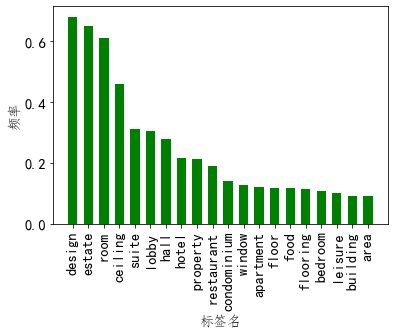

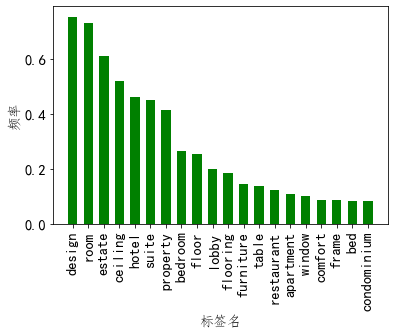

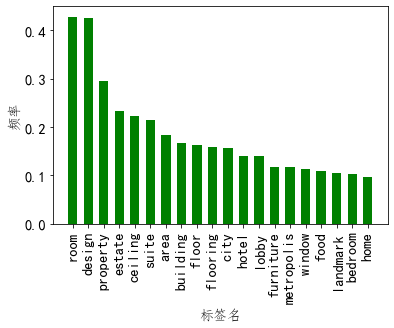

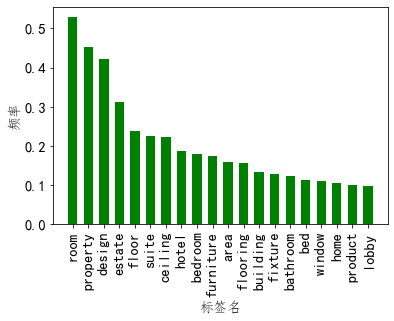

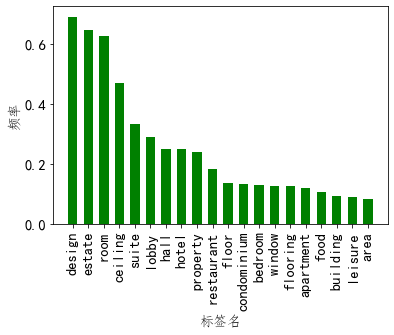

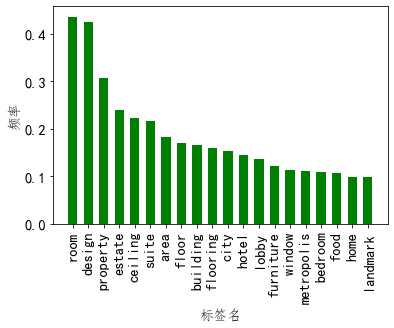

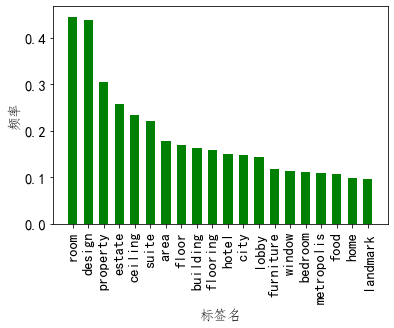

In [20]:
# hist_bar(official_stat_five,'五星级酒店官方图片')
# hist_bar(official_stat_four,'四星级酒店官方图片')
# hist_bar(official_stat_three,'三星级酒店官方图片')
# hist_bar(official_stat_two,'二星级酒店官方图片')

# hist_bar(traveler_stat_five,'五星级酒店旅游者图片')
# hist_bar(traveler_stat_four,'四星级酒店旅游者图片')
# hist_bar(traveler_stat_three,'三星级酒店旅游者图片')
# hist_bar(traveler_stat_two,'二星级酒店旅游者图片')

hist_bar(official_stat_45,'官方图像数据集A')
hist_bar(official_stat_23,'官方图像数据集B')
hist_bar(traveler_stat_45,'旅游图像者数据集A')
hist_bar(traveler_stat_23,'旅游者图像数据集B')

hist_bar(official_stat_all,'官方图像数据集')
hist_bar(traveler_stat_all,'旅游者图像数据集')
hist_bar(all_labels_stat,'所有图像数据集')

In [21]:
# # word_embedding 从字典中查找对应词的向量。 
# '''
# embed_file_name: glove file path.
# word_set: test sets.
# '''
# def load_embedding_file(embed_file_name, word_set):
#     ''' loads embedding file and returns a dictionary (word -> embedding) for the words existing in the word_set '''
#     print("Loading GloVe")
#     embeddings = {}
#     with open(embed_file_name, 'r',encoding='utf-8') as embed_file:
#         for line in embed_file:
# #             print ('line=',line)
#             content = line.strip().split(" ")
#             word = content[0]
# #             print ('word=',word)
#             if word in word_set:
#                 embedding = np.array(content[1:], dtype=np.float32)
#                 embeddings[word] = embedding
#     print("Loaded GloVe")
# #     print ('embeddings=',embeddings)
#     return embeddings

In [22]:
# path = "E:\Master\Research\HotelImageMaterial\glove.840B.300d\glove.840B.300d.txt"  # word_embedding 路径
# official_45_embedding_result_glove = load_embedding_file(path,official_label_all_45)
# official_23_embedding_result_glove = load_embedding_file(path,official_label_all_23)
# traveler_45_embedding_result_glove = load_embedding_file(path,traveler_label_all_45)
# traveler_23_embedding_result_glove = load_embedding_file(path,traveler_label_all_23)


In [23]:
official_label_all_45

['city',
 'waterway',
 'landmark',
 'attraction',
 'area',
 'reflection',
 'sky',
 'water',
 'skyline',
 'building',
 'ceiling',
 'room',
 'suite',
 'design',
 'estate',
 'estate',
 'hotel',
 'room',
 'room',
 'suite',
 'design',
 'ceiling',
 'estate',
 'home',
 'estate',
 'lobby',
 'apartment',
 'room',
 'suite',
 'ceiling',
 'design',
 'estate',
 'hotel',
 'estate',
 'bedroom',
 'plaza',
 'landmark',
 'town',
 'city',
 'square',
 'sky',
 'attraction',
 'use',
 'metropolis',
 'area',
 'room',
 'property',
 'bathroom',
 'ceiling',
 'design',
 'estate',
 'estate',
 'floor',
 'suite',
 'home',
 'waterway',
 'city',
 'landmark',
 'reflection',
 'water',
 'area',
 'sky',
 'skyline',
 'attraction',
 'skyscraper',
 'waterway',
 'city',
 'reflection',
 'area',
 'landmark',
 'water',
 'sky',
 'skyline',
 'attraction',
 'skyscraper',
 'room',
 'room',
 'property',
 'design',
 'suite',
 'estate',
 'ceiling',
 'lobby',
 'treatment',
 'estate',
 'room',
 'suite',
 'ceiling',
 'design',
 'estate',


In [24]:
# google news
GOOGLENEWS_FILE_GLOVE = 'C:\\Users\TF\Desktop\BunCode\GoogleNews-vectors-negative300.bin'
# GOOGLENEWS_FILE_GLOVE = 'E:\毕业论文\BunCode\GoogleNews-vectors-negative300.bin'

def word_embedding_to_vector(path,word_set):
    print('starting')
    embeddings = {}
    embeddings_process=KeyedVectors.load_word2vec_format(path, binary=True)
    
    for word in word_set:
        if word in embeddings_process.vocab:
            embeddings[word]=embeddings_process.word_vec(word)
        else:
            pass
    print ('ending')
    return embeddings

In [25]:
# official_45_embedding_result_googlenews = word_embedding_to_vector(GOOGLENEWS_FILE_GLOVE,official_label_all_45)
# official_23_embedding_result_googlenews = word_embedding_to_vector(GOOGLENEWS_FILE_GLOVE,official_label_all_23)
# traveler_45_embedding_result_googlenews = word_embedding_to_vector(GOOGLENEWS_FILE_GLOVE,traveler_label_all_45)
# traveler_23_embedding_result_googlenews = word_embedding_to_vector(GOOGLENEWS_FILE_GLOVE,traveler_label_all_23)
all_embedding = word_embedding_to_vector(GOOGLENEWS_FILE_GLOVE,all_labels)

starting
ending


In [26]:

# all_embedding_file = pickle.dumps(all_embedding)

with open('all_embedding_hotel.pickle', 'wb') as f:
    pickle.dump(all_embedding, f, protocol=pickle.HIGHEST_PROTOCOL)

In [27]:
with open('all_embedding_hotel.pickle', 'rb') as f:
    all_embedding = pickle.load(f)

In [28]:
def divided (res_emb):
    # 对于可以得到词向量的元素
    mat = [] # 存词向量
    for val in res_emb.values():
        mat.append(val)
    mat_key = [] # 存key值
    for ke in res_emb.keys():
        mat_key.append(ke)
    return mat,mat_key

In [29]:
# official_45_mat,official_45_key = divided(official_45_embedding_result_googlenews)
# official_23_mat,official_23_key = divided(official_23_embedding_result_googlenews)
# traveler_45_mat,traveler_45_key = divided(traveler_45_embedding_result_googlenews)
# traveler_23_mat,traveler_23_key = divided(traveler_23_embedding_result_googlenews)
all_mat,all_key = divided(all_embedding)

In [30]:
# print(dict_keys)

In [31]:
from sklearn.metrics.pairwise import rbf_kernel,laplacian_kernel
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score

In [32]:
arr = np.array(all_mat)
# r, c = arr.shape
# num_clusters, indices = hierarchy_cluster(arr)
# for k, ind in enumerate(indices):
#     lab = []
#     for ttt in ind:
#         lab.append(mat_key[ttt])
arr = pd.DataFrame(arr)
# 利用scipy包进行层次聚类

# lp = laplacian_kernel(arr,gamma=0.05)
rbf =  rbf_kernel(arr,gamma=0.5)  #高斯核
Z = linkage(rbf, method ='ward')#,metric=rbf)#('euclidean')


# cluster = sch.fcluster(Z,t=5,criterion='maxclust') 
# print (len(cluster))
# print (len(all_key))

# cluster_n = list(range(20))[2:]
cluster_n = [12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31]
silhouette_avg = []
for i in cluster_n:
    cluster = sch.fcluster(Z,t=i,criterion='maxclust') 
    silhouette_avg.append(davies_bouldin_score(all_mat, cluster))
print (silhouette_avg)

[4.835227273697578, 4.621493232016842, 4.612510575214894, 4.684957758498612, 4.535198684418774, 4.437057347662851, 4.389536838914818, 4.28509154170298, 4.13741242186161, 4.080435023659114, 4.003945054223897, 3.9094942092782894, 3.832380917381203, 4.716027881044055, 4.59158278489768, 4.521559778227391, 4.418218910543947, 4.317709076940081, 4.209233483961534, 4.164829357501252]


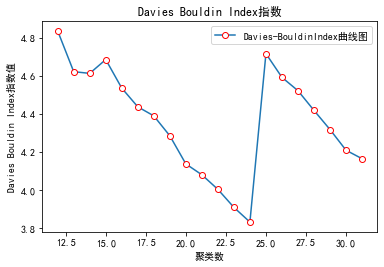

In [33]:
import matplotlib.pyplot as plt
from pylab import *                                 #支持中文
mpl.rcParams['font.sans-serif'] = ['SimHei']

# distances = [8,9,10,11,12,13,14,15,16]

# dbi_list = [1622.4592050715905, 1502.149736283232, 1469.7160379962177, 1370.619858904026, 1246.7293342334567, 684.668871309834, 802.5160147681532, 1144.8552821387746, 1081.5971861525102]

plt.plot(cluster_n, silhouette_avg, marker='o', mec='r', mfc='w',label=u'Davies-BouldinIndex曲线图')
plt.legend()  # 让图例生效
# plt.xticks(distance, names, rotation=45)
# plt.margins(0)
plt.subplots_adjust(bottom=0.15)
plt.xlabel(u"聚类数") #X轴标签
plt.ylabel("Davies Bouldin Index指数值") #Y轴标签
plt.title("Davies Bouldin Index指数") #标题
plt.savefig(r'./导出的图片/DBI.pdf',dpi=300,bbox_inches = 'tight')
plt.savefig(r'./导出的图片/DBI.png',dpi=300,bbox_inches = 'tight')

plt.show()

In [34]:
def bar_vis(cluster_n,silhouette_avg):#支持中文
    mpl.rcParams['font.sans-serif'] = ['SimHei']

    # distances = [8,9,10,11,12,13,14,15,16]

    # dbi_list = [1622.4592050715905, 1502.149736283232, 1469.7160379962177, 1370.619858904026, 1246.7293342334567, 684.668871309834, 802.5160147681532, 1144.8552821387746, 1081.5971861525102]

    plt.plot(cluster_n, silhouette_avg, marker='o', mec='r', mfc='w',label=u'Davies-BouldinIndex曲线图')
    plt.legend()  # 让图例生效
    # plt.xticks(distance, names, rotation=45)
    # plt.margins(0)
    plt.subplots_adjust(bottom=0.15)
    plt.xlabel(u"聚类数") #X轴标签
    plt.ylabel("Davies Bouldin Index指数值") #Y轴标签
    plt.title("Davies Bouldin Index指数") #标题
    # plt.savefig(r'./导出的图片/DBI.pdf',dpi=300,bbox_inches = 'tight')
    # plt.savefig(r'./导出的图片/DBI.png',dpi=300,bbox_inches = 'tight')

    plt.show()

In [35]:

#聚类结果
cluster_result = sch.fcluster(Z,t=24,criterion='maxclust')
clustering_dict = dict(zip(all_key,cluster_result))

#构建字典
dict_keys = {}
for i in clustering_dict.values():
    dict_keys[i] = []

In [36]:
# '''
# 输入：原数据集list，经过聚类之后的字典
# 输出：通过处理之后，将原数据集转化为聚类之后的数据集。该函数结果返回将聚类标签替换为原数据集中的值。
# '''
def transform_into_datasets(dataset_list,clustering_result_dict):
    key_list = list(clustering_result_dict.keys())
    values_list = list(clustering_result_dict.values())
    clustering_in_dataset = []
    for i in dataset_list:
        tmp = []
        for j in i:
            for k in range(0,len(values_list)):
                if j in values_list[k]:
                    tmp.append(key_list[k])
        clustering_in_dataset.append(tmp)
    delete_redis = []
    for i in clustering_in_dataset:
        i = set(i)
        i = list(i)
        delete_redis.append(i)
    return delete_redis

In [37]:
# 将所有数据集进行聚类标签的对应
clustering_result_list_official_45 = transform_into_datasets(official_45_ini,dict_keys)
# print (clustering_result_list_official_45)
clustering_result_list_official_23 = transform_into_datasets(official_23_ini,dict_keys)
clustering_result_list_traveler_45 = transform_into_datasets(traveler_45_ini,dict_keys)
clustering_result_list_traveler_23 = transform_into_datasets(traveler_23_ini,dict_keys)
clustering_result_list_official_all = transform_into_datasets(official_labels_set,dict_keys)
clustering_result_list_traveler_all = transform_into_datasets(traveler_labels_set,dict_keys)
clustering_result_list_all = transform_into_datasets(all_labels_set,dict_keys)


In [38]:
with open('clustering_result_list_official_45_hotel.pickle', 'wb') as f:
    pickle.dump(clustering_result_list_official_45, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    
with open('clustering_result_list_official_23_hotel.pickle', 'wb') as f:
    pickle.dump(clustering_result_list_official_23, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    
with open('clustering_result_list_traveler_45_hotel.pickle', 'wb') as f:
    pickle.dump(clustering_result_list_traveler_45, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    
    
with open('clustering_result_list_traveler_23_hotel.pickle', 'wb') as f:
    pickle.dump(clustering_result_list_traveler_23, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    
    
with open('clustering_result_list_official_all_hotel.pickle', 'wb') as f:
    pickle.dump(clustering_result_list_official_all, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    

with open('clustering_result_list_traveler_all_hotel.pickle', 'wb') as f:
    pickle.dump(clustering_result_list_traveler_all, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    
with open('clustering_result_list_all_hotel.pickle', 'wb') as f:
    pickle.dump(clustering_result_list_all, f, protocol=pickle.HIGHEST_PROTOCOL)
    

In [39]:
cluster_result = sch.fcluster(Z,t=24,criterion='maxclust') 
clustering_dict = dict(zip(all_key,cluster_result))

In [40]:
#构建字典
dict_keys = {}
for i in clustering_dict.values():
    dict_keys[i] = []

In [41]:
#将类别分门别类存入字典中
keys_label = []      
cluster_label = []
for i in clustering_dict.keys():
    keys_label.append(i)
for i in clustering_dict.values():
    cluster_label.append(i)

total = []
for i in range(0,len(keys_label)):
    total.append([keys_label[i],cluster_label[i]])
    
for i in total:
    for j in dict_keys.keys():
        if i[1] == j:
            dict_keys[j].append(i[0])

In [42]:
print (dict_keys)

{11: ['city', 'landmark', 'reflection', 'building', 'design', 'estate', 'lobby', 'town', 'square', 'property', 'structure', 'block', 'architecture', 'infrastructure', 'frame', 'transport', 'court', 'supplies', 'comfort', 'space', 'manager', 'site', 'fun', 'light', 'text', 'product', 'brand', 'resources', 'center', 'rock', 'serveware', 'machine', 'material', 'technology', 'drinkware', 'model', 'covering', 'office', 'stage', 'industry', 'cover', 'sink', 'play', 'shelving', 'supply', 'green', 'equipment', 'tap', 'marketplace', 'joint', 'cool', 'flora', 'heat', 'fire', 'dip', 'library', 'roll', 'male', 'training', 'party', 'market', 'performance', 'energy', 'hardware', 'interaction', 'transportation', 'love', 'village', 'carving', 'classroom', 'service', 'bank', 'formation', 'electricity', 'monitor', 'plastic', 'game', 'media', 'barware', 'document', 'website', 'paper', 'laptop', 'communication', 'school', 'writing', 'software', 'care', 'fauna', 'collection', 'sign', 'products', 'mirror', 

In [43]:
'''
输入：原数据集list，经过聚类之后的字典
输出：通过处理之后，将原数据集转化为聚类之后的数据集。该函数结果返回将聚类标签替换为原数据集中的值。
'''
def transform_into_datasets(dataset_list,clustering_result_dict):
    key_list = list(clustering_result_dict.keys())
    values_list = list(clustering_result_dict.values())
    clustering_in_dataset = []
    for i in dataset_list:
        tmp = []
        for j in i:
            for k in range(0,len(values_list)):
                if j in values_list[k]:
                    tmp.append(key_list[k])
        clustering_in_dataset.append(tmp)
    delete_redis = []
    for i in clustering_in_dataset:
        i = set(i)
        i = list(i)
        delete_redis.append(i)  
    return delete_redis

In [44]:
# 将所有数据集进行聚类标签的对应
clustering_result_list_official_45 = transform_into_datasets(official_45_ini,dict_keys)
clustering_result_list_official_23 = transform_into_datasets(official_23_ini,dict_keys)
clustering_result_list_traveler_45 = transform_into_datasets(traveler_45_ini,dict_keys)
clustering_result_list_traveler_23 = transform_into_datasets(traveler_23_ini,dict_keys)
clustering_result_list_official_all = transform_into_datasets(official_labels_set,dict_keys)
clustering_result_list_traveler_all = transform_into_datasets(traveler_labels_set,dict_keys)
clustering_result_list_all = transform_into_datasets(all_labels_set,dict_keys)

In [45]:
# 对聚类之后的标签进行统计以方便后面的对比
label_stat_official_45,label_fre_official_45 = label_stat(clustering_result_list_official_45)
label_stat_official_23,label_fre_official_23 = label_stat(clustering_result_list_official_23)
label_stat_traveler_45,label_fre_traveler_45 = label_stat(clustering_result_list_traveler_45)
label_stat_traveler_23,label_fre_traveler_23 = label_stat(clustering_result_list_traveler_23)
label_stat_official_all,label_fre_official_all = label_stat(clustering_result_list_traveler_45)
label_stat_traveler_all,label_fre_traveler_all = label_stat(clustering_result_list_traveler_23)
label_stat_all,label_fre_all = label_stat(clustering_result_list_all)

### 频繁项集挖掘

In [46]:
# 频繁项集
def fre_item(itemsets):
    lenth = len(itemsets)
    itemsets = frequent_itemsets(itemsets,0.00015)
    itemlist = list(itemsets)
    frequentItem = [(item[0],item[1]/lenth) for item in itemlist]
    return frequentItem

In [47]:
frequent_result_official_45 = fre_item(clustering_result_list_official_45)
frequent_result_official_23 = fre_item(clustering_result_list_official_23)
frequent_result_traveler_45 = fre_item(clustering_result_list_traveler_45)
frequent_result_traveler_23 = fre_item(clustering_result_list_traveler_23)
frequent_result_official_all = fre_item(clustering_result_list_official_all)
frequent_result_traveler_all = fre_item(clustering_result_list_traveler_all)
frequent_result_all = fre_item(clustering_result_list_all)  # 得到二维数组


with open('frequent_result_official_45_hotel.pickle', 'wb') as f:
    pickle.dump(frequent_result_official_45, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    
with open('frequent_result_official_23_hotel.pickle', 'wb') as f:
    pickle.dump(frequent_result_official_23, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    
with open('frequent_result_traveler_45_hotel.pickle', 'wb') as f:
    pickle.dump(frequent_result_traveler_45, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    
with open('frequent_result_traveler_23_hotel.pickle', 'wb') as f:
    pickle.dump(frequent_result_traveler_23, f, protocol=pickle.HIGHEST_PROTOCOL)


with open('frequent_result_official_all_hotel.pickle', 'wb') as f:
    pickle.dump(frequent_result_official_all, f, protocol=pickle.HIGHEST_PROTOCOL)
    

with open('frequent_result_traveler_all_hotel.pickle', 'wb') as f:
    pickle.dump(frequent_result_traveler_all, f, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('frequent_result_all_hotel.pickle', 'wb') as f:
    pickle.dump(frequent_result_all, f, protocol=pickle.HIGHEST_PROTOCOL)


In [48]:
# 去掉重复包含项
def quchong(frequentItem):
    result=[]   # 存放官方图片的频繁项集
    for i in range(0,len(frequentItem)):
        for j in range(i,len(frequentItem)):
            if (set(frequentItem[i][0]).issubset(frequentItem[j][0])== True):
                if (frequentItem[i][1] == frequentItem[j][1]):
                    if ((len(frequentItem[i][0])) < (len(frequentItem[j][0]))):
                        frequentItem[i] = "redundancy"
    for i in range(0,len(frequentItem)):
        if frequentItem[i] != "redundancy":
            result.append(frequentItem[i])
#     print (result)
    return result

# 按照频繁项集support排序[label:support]按照support值排序
def sortbysup(result):
    n = len(result)
    for i in range(n-1):
        for j in range(n-i-1):
            if result[j][1]<result[j+1][1]:
                result[j],result[j+1] = result[j+1],result[j]
#     print ("result = ",result)
    return result

def sortbysup_1(result):
    n = len(result)
    for i in range(n-1):
        for j in range(n-i-1):
            if result[j][3]<result[j+1][3]:
                result[j],result[j+1] = result[j+1],result[j]
#     print ("result = ",result)
    return result   

# 按照频繁项集长度排序
def sortbylen(result):
    n = len(result)
    for i in range(n-1):
        for j in range(n-i-1):
            if len(result[j][0])>len(result[j+1][0]):
                result[j],result[j+1] = result[j+1],result[j]
#     print ("result = ",result)
    return result

### 对比

In [49]:
def contrast_result(A,B):
    co_support = sortbysup(quchong(fre_item(A)))
    open_support = sortbysup(quchong(fre_item(B)))
    support = sortbysup(quchong(fre_item(A+B)))

    fre_co = []
    for i in co_support:
        fre_co.append(i[0])
    # print (fre_co)

    # print ("======================================================================")
    fre_open = []
    for i in open_support:
        fre_open.append(i[0])
    # print (fre_open)

    # 找出两边都包含的itemsets
    ppp = [l for l in fre_co if l in fre_open]
    # print (ppp)

    a = []
    for i in ppp:
        for j in co_support:
            if i == j[0]:
                a.append([i,j[1]])
    # print (a)

    b = []
    for i in ppp:
        for j in open_support:
            if i == j[0]:
                b.append([i,j[1]])
    # print (b)

    co_contrast_ratio = []
    for i in range(0,len(ppp)):
        co_contrast_ratio.append([ppp[i],round(a[i][1],5),round(b[i][1],5),round(a[i][1]/b[i][1],5)])
    # print ("contrast ratio A > B = ",co_contrast_ratio)

    print ("排序1：  ",sortbysup_1(co_contrast_ratio))

    open_contrast_ratio = []
    for i in range(0,len(ppp)):
        open_contrast_ratio.append([ppp[i],round(b[i][1],5),round(a[i][1],5),round(b[i][1]/a[i][1],5)])
    # print ("contrast ratio B > A = ",open_contrast_ratio)
    print('================================================================================================')
    print ("排序2：   ",sortbysup_1(open_contrast_ratio))

    contrast_diff = []
    for i in range(0,len(ppp)):
        contrast_diff.append([ppp[i],abs(round(a[i][1]/b[i][1],16))])
    # print ("contrast different = ", contrast_diff)

In [50]:
# # print("官方总数据集 vs 旅游者总数据集")
contrast_official_traveler = contrast_result(clustering_result_list_official_all,clustering_result_list_traveler_all)
# print(len(contrast_official_traveler))

# print("官方数据集A vs 官方数据集B")
contrast_official_45_vs_23 = contrast_result(clustering_result_list_official_45,clustering_result_list_official_23)
# print (len(contrast_official_45_vs_23))

# # print("旅游者数据集A vs 旅游者数据集B")
contrast_traveler_45_vs_23 = contrast_result(clustering_result_list_traveler_45,clustering_result_list_traveler_23)
# print (len(contrast_traveler_45_vs_23))


with open('contrast_official_traveler_hotel.pickle', 'wb') as f:
    pickle.dump(contrast_official_traveler, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    
    
with open('contrast_official_45_vs_23_hotel.pickle', 'wb') as f:
    pickle.dump(contrast_official_45_vs_23, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    
    
with open('contrast_traveler_45_vs_23_hotel.pickle', 'wb') as f:
    pickle.dump(contrast_traveler_45_vs_23, f, protocol=pickle.HIGHEST_PROTOCOL)



排序1：   [[frozenset({10, 11, 13, 7}), 0.00125, 0.00027, 4.59646], [frozenset({10, 11, 22}), 0.00083, 0.00029, 2.86002], [frozenset({16, 10, 7}), 0.00167, 0.00062, 2.68127], [frozenset({17, 5, 6, 7, 10}), 0.00042, 0.00016, 2.68127], [frozenset({10, 19, 7}), 0.00042, 0.00016, 2.68127], [frozenset({16, 7}), 0.00209, 0.0008, 2.61587], [frozenset({3, 6, 7}), 0.00083, 0.00035, 2.38335], [frozenset({10, 11, 4, 13}), 0.00042, 0.00019, 2.14501], [frozenset({10, 14}), 0.00083, 0.00043, 1.95001], [frozenset({5, 6, 7, 10, 11}), 0.00042, 0.00021, 1.95001], [frozenset({10, 3, 7}), 0.00167, 0.00091, 1.82554], [frozenset({14}), 0.00125, 0.00072, 1.7392], [frozenset({10, 5, 6, 7}), 0.00125, 0.00074, 1.69343], [frozenset({10, 11, 6}), 0.00626, 0.00371, 1.68457], [frozenset({3, 7}), 0.00209, 0.0013, 1.60076], [frozenset({11, 6}), 0.00668, 0.00443, 1.50527], [frozenset({14, 7}), 0.00083, 0.00056, 1.47932], [frozenset({10, 11, 6, 7}), 0.00459, 0.00321, 1.43001], [frozenset({10, 14, 7}), 0.00042, 0.00029, 1.

排序1：   [[frozenset({17, 10, 7}), 0.00353, 0.00024, 14.6397], [frozenset({2, 5, 7, 10, 11}), 0.00104, 0.00024, 4.29548], [frozenset({1, 2, 5, 10, 11}), 0.00195, 0.00048, 4.03249], [frozenset({1, 10, 11, 5}), 0.00785, 0.00241, 3.25229], [frozenset({1, 10, 5}), 0.00859, 0.00265, 3.23556], [frozenset({11, 2, 10, 7}), 0.00154, 0.00048, 3.1997], [frozenset({2, 10, 5, 7}), 0.00133, 0.00048, 2.76138], [frozenset({2, 10, 7}), 0.00199, 0.00072, 2.74677], [frozenset({5, 10, 11, 13}), 0.00393, 0.00145, 2.71755], [frozenset({1, 10, 11}), 0.02211, 0.00845, 2.61736], [frozenset({1, 11}), 0.02257, 0.00869, 2.59823], [frozenset({11, 2, 10, 5}), 0.04734, 0.01882, 2.51525], [frozenset({1, 10}), 0.02583, 0.01038, 2.48922], [frozenset({1}), 0.0268, 0.0111, 2.41454], [frozenset({2, 10, 5}), 0.04804, 0.02003, 2.39858], [frozenset({10, 11, 6, 7}), 0.00336, 0.00145, 2.32307], [frozenset({10, 11, 6}), 0.00389, 0.00169, 2.30428], [frozenset({11, 2, 10}), 0.07292, 0.03282, 2.22187], [frozenset({2, 11}), 0.07334, 

In [51]:
# print("官方数据集A vs 官方数据集B")
# contrast_official_45_vs_23 = contrast_result(clustering_result_list_official_45,clustering_result_list_official_23)

# print("旅游者数据集A vs 旅游者数据集B")
# contrast_traveler_45_vs_23 = contrast_result(clustering_result_list_traveler_45,clustering_result_list_traveler_23)

# print("官方数据集A vs 旅游者数据集A")   # 可以无
# contrast_45_vs_45 = contrast_result(clustering_result_list_official_45,clustering_result_list_traveler_45)

# print("官方数据集B vs 旅游者数据集B")  # 可以无
# contrast_23_vs_23 = contrast_result(clustering_result_list_official_23,clustering_result_list_traveler_23)

# print("官方总数据集 vs 旅游者总数据集")
# contrast_official_traveler = contrast_result(clustering_result_list_official_all,clustering_result_list_traveler_all)

In [52]:
arr = np.array(all_mat)
# r, c = arr.shape
# num_clusters, indices = hierarchy_cluster(arr)
# for k, ind in enumerate(indices):
#     lab = []
#     for ttt in ind:
#         lab.append(mat_key[ttt])
arr = pd.DataFrame(arr)
# 利用scipy包进行层次聚类
# Z = linkage(arr, method ='average',metric='euclidean')

rbf =  rbf_kernel(arr,gamma=-1.4)
Z = linkage(rbf, method ='weighted')#,metric=rbf)#('euclidean')

# cluster = sch.fcluster(Z,t=5,criterion='maxclust') 
# print (len(cluster))
# print (len(all_key))

cluster_n = list(range(21))[2:]
silhouette_avg = []
for i in cluster_n:
    cluster = sch.fcluster(Z,t=i,criterion='maxclust') 
    silhouette_avg.append(silhouette_score(all_mat, cluster,metric='euclidean'))
print (silhouette_avg)

[0.25840926, 0.19483833, 0.18960962, 0.14569175, 0.1312048, 0.12939219, 0.12724139, 0.10870973, 0.10739323, 0.10472069, 0.096501134, 0.09133986, 0.09036103, 0.08640471, 0.08148441, 0.0751563, 0.07422112, 0.07355704, 0.06694315]


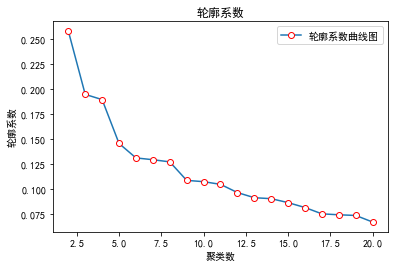

In [53]:
import matplotlib.pyplot as plt
from pylab import *                                 #支持中文
mpl.rcParams['font.sans-serif'] = ['SimHei']

# distances = [8,9,10,11,12,13,14,15,16]

# dbi_list = [1622.4592050715905, 1502.149736283232, 1469.7160379962177, 1370.619858904026, 1246.7293342334567, 684.668871309834, 802.5160147681532, 1144.8552821387746, 1081.5971861525102]

plt.plot(cluster_n, silhouette_avg, marker='o', mec='r', mfc='w',label=u'轮廓系数曲线图')
plt.legend()  # 让图例生效
# plt.xticks(distance, names, rotation=45)
# plt.margins(0)
plt.subplots_adjust(bottom=0.15)
plt.xlabel(u"聚类数") #X轴标签
plt.ylabel("轮廓系数") #Y轴标签
plt.title("轮廓系数") #标题
plt.savefig(r'./导出的图片/轮廓系数.pdf',dpi=300,bbox_inches = 'tight')
plt.savefig(r'./导出的图片/轮廓系数.png',dpi=300,bbox_inches = 'tight')

plt.show()

In [54]:
# # 将word embedding 结果分为匹配和未匹配的内容分开来保存
# labels_res = [] # 存label值
# score_res = [] #存score值
# for ke in res_emb.keys():
#     labels_res.append(ke)
# for sco in res_emb.values():
#     score_res.append(sco)
# last_res = []   # 可以通过word embedding 查出来的
# len1 = len(labels_res)
# len2 = len(merge)
# for merg in range(0,len2):
#     for emb in range(0,len1):
#         if merge[merg][0][0] == labels_res[emb]:
#             last_res.append(merge[merg])
# # print ("通过word embedding 匹配出来的集合：",last_res)
# not_in = [] # 没有通过word embedding查出来的集合
# for i in merge:
#     if i not in last_res:
#         not_in.append(i)
# # print ("通过word embedding 没有匹配出来的集合：",not_in)

In [55]:
# # 对于可以得到词向量的元素
# mat = [] # 存词向量
# for val in res_emb.values():
#     mat.append(val)
# mat_key = [] # 存key值
# for ke in res_emb.keys():
#     mat_key.append(ke)

In [56]:
# 进行层次聚类
def hierarchy_cluster(data, method='average', threshold=5.0):
    '''层次聚类
    Arguments:
        data [[0, float, ...], [float, 0, ...]] -- 文档 i 和文档 j 的距离
    Keyword Arguments:
        method {str} -- [linkage的方式： single、complete、average、centroid、median、ward] (default: {'average'})
        threshold {float} -- 聚类簇之间的距离
    Return:
        cluster_number int -- 聚类个数
        cluster [[idx1, idx2,..], [idx3]] -- 每一类下的索引
    '''
    data = np.array(data)
    Z = linkage(data, method=method)
    cluster_assignments = fcluster(Z, threshold, criterion='distance')
    num_clusters = cluster_assignments.max()
    indices = get_cluster_indices(cluster_assignments)
    return num_clusters, indices

In [57]:
# 对于聚类结果进行映射
def get_cluster_indices(cluster_assignments):
    '''映射每一类至原数据索引
    Arguments:
        cluster_assignments 层次聚类后的结果
    Returns:
        [[idx1, idx2,..], [idx3]] -- 每一类下的索引
    '''
    n = cluster_assignments.max()
#     print ("n = ",n)
    indices = []
    for cluster_number in range(1, n + 1):
        indices.append(np.where(cluster_assignments == cluster_number)[0])
    return indices

In [58]:
# arr = np.array(all_mat)
# # r, c = arr.shape
# # num_clusters, indices = hierarchy_cluster(arr)
# # for k, ind in enumerate(indices):
# #     lab = []
# #     for ttt in ind:
# #         lab.append(mat_key[ttt])
# arr = pd.DataFrame(arr)
# # 利用scipy包进行层次聚类
# Z = linkage(arr, method ='ward',metric='euclidean')


# print (Z)
# plt.title('Hierarchical Clustering')
# plt.ylabel('distance')
# max_d = 150
# t = dendrogram(Z,labels = all_key,
#                truncate_mode='lastp',  # show only the last p merged clusters
#                p=2000,  # show only the last p merged clusters
#                leaf_rotation=90.,
#                leaf_font_size=1.4,
#                show_leaf_counts=True,
#                show_contracted=True, # to get a distribution impression in truncated branches
#               )
# # plt.savefig(r'./导出的图片/all_label.png', dpi=800)
# plt.show()

In [59]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)
    ddata = dendrogram(*args, **kwargs)
    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

### DBI指数

In [60]:
# 计算DBI指数
def compute_s(i, x, clusters):
    norm_c= len(clusters)
    s = 0
    for x in clusters:
        s += distance.euclidean(x, clusters[i])
    return s
def compute_Rij(i, j, x, clusters, nc):
    Rij = 0
    try:
        d = distance.euclidean(clusters[i],clusters[j])
        Rij = (compute_s(i, x, clusters) + compute_s(j, x, clusters))/d
    except:
        Rij = 0
    return Rij
def compute_R(i, x, clusters, nc): 
    list_r = []
    for i in range(nc):
        for j in range(nc):
            if(i!=j):
                temp = compute_Rij(i, j, x, clusters, nc)
                list_r.append(temp)
    return max(list_r)
def compute_DB_index(x, clusters, nc):
    sigma_R = 0.0
    for i in range(nc):
        sigma_R = sigma_R + compute_R(i, x, clusters, nc)
    DB_index = float(sigma_R)/float(nc)
    return DB_index

ValueError: max() arg is an empty sequence

D:\python\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 226 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\python\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 251 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\python\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 238 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\python\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 226 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\python\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 251 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\python\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 238 missing from current font.
  font.set_text(s, 0, flags=flags)


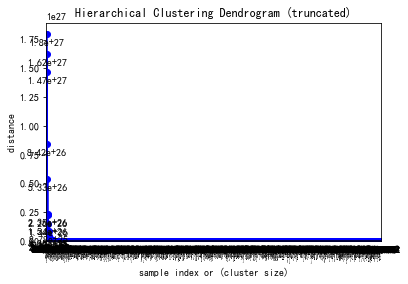

In [61]:
dbi_list = []
cluster_list = []
distances = [6,7,8,9,10,11,12,12.5,13,14,15,16,17,18,19]
for distance_d in distances:
    figure1 = (fancy_dendrogram(
        Z,
        labels = all_key,
        truncate_mode='lastp',
        p=2000,
        leaf_rotation=90.,
        leaf_font_size=2.2,
        show_contracted=True,
        annotate_above=10,
        max_d= distance_d,  # plot a horizontal cut-off line
    ))
    values_figure = []
    for fig in figure1.values():
        values_figure.append(fig)

    x_list = values_figure[2]
    x_index = values_figure[3]
    x_color = values_figure[4]
    x_color.insert(0,x_color[0])
    
#     print (x_list)
#     print (x_index)
#     print (x_color)
    
#     将不同cluster元素放一起（color_list）
    clu = [(list(v)) for k,v in groupby(x_color)]
    disp = []
    a = 0
    for strin in range(0,len(x_index)):
        x_index[strin] = str(x_index[strin])   
    for c in clu:
        temp = []
        for l in range(0,len(c)):
            if a>len(x_color):
                break
            t = l+a
            temp.append(x_index[t])
        a += len(c)
        disp.append(temp)  
    
    # 按cluster将词分好
    disp_list = [] # 存放分好的词
    a = 0
    for c in clu:
        temp = []
        for l in range(0,len(c)):
            if a>len(x_color):
                break
            t = l+a
            temp.append(x_list[t])
        a += len(c)
        disp_list.append(temp)
    n_clusters = len(disp_list)   
    # 按cluster将词的index分好
    for strin in range(0,len(x_index)):
        x_index[strin] = int(x_index[strin])
    
    disp_values = []        
    a = 0
    for c in disp:
        temp = []
        for l in range(0,len(c)):
            if a>len(x_color):
                break
            t = l+a
            temp.append(all_mat[x_index[t]])
        a += len(c)
        disp_values.append(temp)
        
    #计算每个簇的中心点
    centroids = []
    for j in range(0,len(disp_values)):
        numm = 0
        for i in disp_values[j]:
            numm += i
        centroids.append(numm)
        
    # DBI值
    index_db_val = compute_DB_index(all_mat, centroids, n_clusters)
    dbi_list.append(index_db_val)
    cluster_list.append(n_clusters)
    
print (dbi_list)
print (cluster_list)

In [ ]:
print (dbi_list)
print (cluster_list)

In [ ]:
import matplotlib.pyplot as plt
from pylab import *                                 #支持中文
mpl.rcParams['font.sans-serif'] = ['SimHei']

# distances = [8,9,10,11,12,13,14,15,16]

# dbi_list = [1622.4592050715905, 1502.149736283232, 1469.7160379962177, 1370.619858904026, 1246.7293342334567, 684.668871309834, 802.5160147681532, 1144.8552821387746, 1081.5971861525102]

plt.plot(distances, dbi_list, marker='o', mec='r', mfc='w',label=u'Davies-BouldinIndex曲线图')
plt.legend()  # 让图例生效
# plt.xticks(distance, names, rotation=45)
# plt.margins(0)
plt.subplots_adjust(bottom=0.15)
plt.xlabel(u"distance") #X轴标签
plt.ylabel("Davies Bouldin Index指数值") #Y轴标签
plt.title("Davies Bouldin Index指数") #标题
plt.savefig(r'./导出的图片/DBI.pdf',dpi=300,bbox_inches = 'tight')
plt.savefig(r'./导出的图片/DBI.png',dpi=300,bbox_inches = 'tight')

plt.show()

In [ ]:
figure1 = (fancy_dendrogram(
    Z,
    labels = all_key,
    truncate_mode='lastp',
    p=2000,
    leaf_rotation=90.,
    leaf_font_size=2.2,
    show_contracted=True,
    annotate_above=10,
    max_d= 12,  # plot a horizontal cut-off line
))
# print (figure1)
values_figure = []
for fig in figure1.values():
    values_figure.append(fig)

x_list = values_figure[2]
x_index = values_figure[3]
x_color = values_figure[4]
x_color.insert(0,x_color[0])

### DI指数

In [ ]:
#DI指数
import numpy as np

def normalize_to_smallest_integers(labels):
    """Normalizes a list of integers so that each number is reduced to the minimum possible integer, maintaining the order of elements.
    :param labels: the list to be normalized
    :returns: a numpy.array with the values normalized as the minimum integers between 0 and the maximum possible value.
    """

    max_v = len(set(labels)) if -1 not in labels else len(set(labels)) - 1
    sorted_labels = np.sort(np.unique(labels))
    unique_labels = range(max_v)
    new_c = np.zeros(len(labels), dtype=np.int32)

    for i, clust in enumerate(sorted_labels):
        new_c[labels == clust] = unique_labels[i]

    return new_c


def dunn(labels, distances):
    """
    Dunn index for cluster validation (the bigger, the better)
    
    .. math:: D = \\min_{i = 1 \\ldots n_c; j = i + 1\ldots n_c} \\left\\lbrace \\frac{d \\left( c_i,c_j \\right)}{\\max_{k = 1 \\ldots n_c} \\left(diam \\left(c_k \\right) \\right)} \\right\\rbrace
    
    where :math:`d(c_i,c_j)` represents the distance between
    clusters :math:`c_i` and :math:`c_j`, given by the distances between its
    two closest data points, and :math:`diam(c_k)` is the diameter of cluster
    :math:`c_k`, given by the distance between its two farthest data points.
    
    The bigger the value of the resulting Dunn index, the better the clustering
    result is considered, since higher values indicate that clusters are
    compact (small :math:`diam(c_k)`) and far apart.
    :param labels: a list containing cluster labels for each of the n elements
    :param distances: an n x n numpy.array containing the pairwise distances between elements
    
    .. [Kovacs2005] Kovács, F., Legány, C., & Babos, A. (2005). Cluster validity measurement techniques. 6th International Symposium of Hungarian Researchers on Computational Intelligence.
    """

    labels = normalize_to_smallest_integers(labels)

    unique_cluster_distances = np.unique(min_cluster_distances(labels, distances))
    max_diameter = max(diameter(labels, distances))

    if np.size(unique_cluster_distances) > 1:
        return unique_cluster_distances[1] / max_diameter
    else:
        return unique_cluster_distances[0] / max_diameter


def min_cluster_distances(labels, distances):
    """Calculates the distances between the two nearest points of each cluster.
    :param labels: a list containing cluster labels for each of the n elements
    :param distances: an n x n numpy.array containing the pairwise distances between elements
    """
    labels = normalize_to_smallest_integers(labels)
    n_unique_labels = len(np.unique(labels))

    min_distances = np.zeros((n_unique_labels, n_unique_labels))
    for i in np.arange(0, len(labels) - 1):
        for ii in np.arange(i + 1, len(labels)):
            if labels[i] != labels[ii] and distances[i, ii] > min_distances[labels[i], labels[ii]]:
                min_distances[labels[i], labels[ii]] = min_distances[labels[ii], labels[i]] = distances[i, ii]
    return min_distances


def diameter(labels, distances):
    """Calculates cluster diameters (the distance between the two farthest data points in a cluster)
    :param labels: a list containing cluster labels for each of the n elements
    :param distances: an n x n numpy.array containing the pairwise distances between elements
    :returns:
    """
    labels = normalize_to_smallest_integers(labels)
    n_clusters = len(np.unique(labels))
    diameters = np.zeros(n_clusters)

    for i in np.arange(0, len(labels) - 1):
        for ii in np.arange(i + 1, len(labels)):
            if labels[i] == labels[ii] and distances[i, ii] > diameters[labels[i]]:
                diameters[labels[i]] = distances[i, ii]
    return diameters

In [ ]:
di_list = []
cluster_list = []
distances = [6,7,8,9,10,11,12,12.5,13,14,15,16,17,18,19]
for distance_d in distances:
    figure1 = (fancy_dendrogram(
        Z,
        labels = all_key,
        truncate_mode='lastp',
        p=2000,
        leaf_rotation=90.,
        leaf_font_size=2.2,
        show_contracted=True,
        annotate_above=10,
        max_d= distance_d,  # plot a horizontal cut-off line
    ))
    # print (figure1)
    values_figure = []
    for fig in figure1.values():
        values_figure.append(fig)

    x_list = values_figure[2]
    x_index = values_figure[3]
    x_color = values_figure[4]
    x_color.insert(0,x_color[0])
    
    # 将不同cluster元素放一起（color_list）
    clu = [(list(v)) for k,v in groupby(x_color)]
    disp = []
    a = 0
    for strin in range(0,len(x_index)):
        x_index[strin] = str(x_index[strin])   
    for c in clu:
        temp = []
        for l in range(0,len(c)):
            if a>len(x_color):
                break
            t = l+a
            temp.append(x_index[t])
        a += len(c)
        disp.append(temp)
        
    # 按cluster将词分好
    disp_list = [] # 存放分好的词
    a = 0
    for c in clu:
        temp = []
        for l in range(0,len(c)):
            if a>len(x_color):
                break
            t = l+a
            temp.append(x_list[t])
        a += len(c)
        disp_list.append(temp)
    n_clusters = len(disp_list)
    k_list = []
    for inte in disp_list:
        for inte2 in inte:
            k_list.append(inte2)     
    
    k_value = []
    for c in range(0,len(all_key)):
        for d in k_list:
            if all_key[c] == d:
                k_value.append(all_mat[c]) 
        
    # 按cluster将词的index分好
    for strin in range(0,len(x_index)):
        x_index[strin] = int(x_index[strin])
    disp_values = []        
    a = 0
    for c in disp:
        temp = []
        for l in range(0,len(c)):
            if a>len(x_color):
                break
            t = l+a
            temp.append(all_mat[x_index[t]])
        a += len(c)
        disp_values.append(temp) 
        
    clu_list = [(list(v)) for k,v in groupby(x_color)]
    res_clusters = []
    for cl in range(0,len(clu_list)):
        temp_cl = []
        for i in range(0,len(clu_list[cl])):
            temp_cl.append(cl)
        res_clusters.append(temp_cl)
    k_res = []
    for j in res_clusters:
        for x in j:
            k_res.append(x)

    dunk = dunn(k_res, euclidean_distances(k_value))
    di_list.append(dunk)
    cluster_list.append(n_clusters)
    
print (di_list)
print (cluster_list)

In [ ]:
import matplotlib.pyplot as plt
from pylab import *                                 #支持中文
mpl.rcParams['font.sans-serif'] = ['SimHei']


di_list = [0.4866599472044431, 0.5064838085954556, 0.5064838085954556, 0.6363254524054349, 0.6169771987226317, 0.5814802263186812, 0.7313846968589413, 0.7405891274563829, 0.6373614458794155, 0.6214510530001571, 0.6636865398027285, 0.6636865398027285, 0.6636865398027285, 0.7848477496143985]

# di_list=[0.5064838085954556, 0.6363254524054349, 0.6169771987226317, 0.5814802263186812, 0.7313846968589413, 0.7205891274563829, 0.6373614458794155, 0.6214510530001571, 0.6636865398027285]
# # cluster_list=[72, 50, 36, 32, 23, 20, 15, 13, 10, 8, 8]
# distances = [8,9,10,11,12,13,14,15,16]

plt.plot(distances, di_list, marker='o', mec='r', mfc='w',label=u'Dunn Validity Index曲线图')
plt.legend()  # 让图例生效
plt.subplots_adjust(bottom=0.15)
plt.xlabel(u"distance") #X轴标签
plt.ylabel("Dunn Validity Index指数值") #Y轴标签
plt.title("Dunn Validity Index指数") #标题
plt.savefig(r'./导出的图片/DVI.pdf',dpi=300,bbox_inches = 'tight')
plt.savefig(r'./导出的图片/DVI.png',dpi=300,bbox_inches = 'tight')
plt.show()